In [1]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [2]:
# Inspect the input data
import time
import glob
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import normalizeIMG, real_files_to_tensors, window_mean
from utils import minmax_normalize_param, unnormalize_params

from models import encoderDecoderModel

# some initializations
# data_dir = './tomo_data/REAL_DATA_Run2'
data_dir = './tomo_data/REAL_DATA_Run2_2'

IMG_OUTPUT_SIZE = 128
latent_dim = 7  # 6 + the new VrfSPS

zeropad = 14
start_turn = 1
skipturns = 3
Ib = 1.16e11

normalization = 'minmax'
img_normalize = 'off'
ps_normalize = 'off'

E_normFactor = 25000000000.0
B_normFactor = 800000000.0
T_normFactor = 28000000000.0

var_names = ['phEr', 'enEr', 'bl','inten', 'Vrf', 'mu', 'VrfSPS']
loss_weights = [0, 1, 2, 3, 4, 5, 6]

# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
enc_timestamp = 'best_encoder_TF_new'
dec_timestamp = 'best_decoder_TF_new'


2023-04-23 14:45:16.761600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-23 14:45:16.761617: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:

wf_test_orig, wf_id, bunch_profiles_orig = real_files_to_tensors(data_dir,
                                                                 Ib=Ib,
                                                                 T_normFactor=T_normFactor,
                                                                 corrTriggerOffset=False)
print(wf_test_orig.shape)
print(bunch_profiles_orig.shape)
print('Max value in wf: ', np.max(wf_test_orig))
print('Min value in wf: ', np.min(wf_test_orig))

# Correct the input data
wf_test, _, bunch_profiles = real_files_to_tensors(data_dir,
                                                   Ib=Ib,
                                                   T_normFactor=T_normFactor,
                                                   corrTriggerOffset=True)



(48, 128, 128, 1)
(48, 128, 326, 1)
Max value in wf:  0.17084678
Min value in wf:  -0.0050347224


2023-04-23 14:45:23.172142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-23 14:45:23.172174: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-23 14:45:23.172197: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kiliakis-ubuntu): /proc/driver/nvidia/version does not exist
2023-04-23 14:45:23.174021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


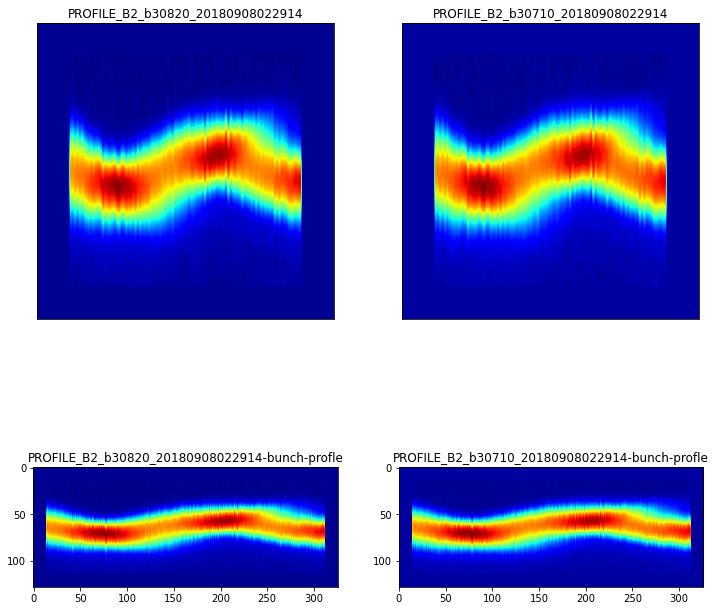

In [4]:
%matplotlib inline
# plot some of the outputs

nrows = 2
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(wf_test_orig)),
                          size=nrows, replace=False)

samples_X = tf.gather(wf_test_orig, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(sample)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in sample[i]])
    ax.set_title(f'{wf_id[i]}')

    ax = axes[i+2]
    # show the image
    ax.imshow(bunch_profiles_orig[sample[i]], cmap='jet')
    ax.set_title(f'{wf_id[i]}-bunch-profle')


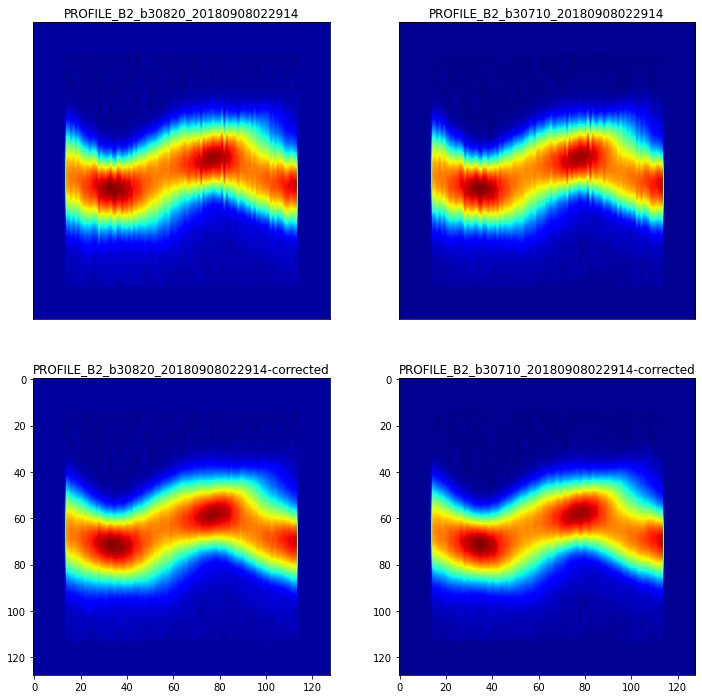

In [5]:


nrows = 2
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(wf_test_orig)),
                          size=nrows, replace=False)

samples_X = tf.gather(wf_test_orig, sample)
samples_X_corrected = tf.gather(wf_test, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
# for i in range(len(axes)):
for i in range(len(sample)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(samples_X[i], cmap='jet')
    ax.set_title(f'{wf_id[i]}')

    ax = axes[i+2]
    # show the image
    ax.imshow(samples_X_corrected[i], cmap='jet')
    ax.set_title(f'{wf_id[i]}-corrected')


## Testing the models on the real data

In [6]:
# Load the model
print('Encoder: ', enc_timestamp)

# Initialize directories
enc_trial_dir = os.path.join('./trials/', enc_timestamp)
enc_weights_dir = os.path.join(enc_trial_dir, 'weights')
assert os.path.exists(enc_weights_dir)

print('Decoder: ', dec_timestamp)

# Initialize directories
dec_trial_dir = os.path.join('./trials/', dec_timestamp)
dec_weights_dir = os.path.join(dec_trial_dir, 'weights')
assert os.path.exists(dec_weights_dir)

# initialize directory to save the plots
timestamp = f'enc_{enc_timestamp}_dec_{dec_timestamp}'
print('Timestamp: ', timestamp)
plots_dir = os.path.join('./plots', 'end_to_end', timestamp)
os.makedirs(plots_dir, exist_ok=True)

encDec = encoderDecoderModel(enc_weights_dir, dec_weights_dir,
 loss_weights=loss_weights)

# for model in (encDec.encoder.model):
#     print(model.summary())


Encoder:  best_encoder_TF_new
Decoder:  best_decoder_TF_new
Timestamp:  enc_best_encoder_TF_new_dec_best_decoder_TF_new


In [7]:
# normalize the turns
# select a number of turns (31)
selected_turns = np.linspace(1, 298, num=28, endpoint=True, dtype=np.float32)
print(selected_turns)
norm_turns = minmax_normalize_param(selected_turns, np.min(selected_turns),
                                    np.max(selected_turns),
                                    target_range=(0, 1))


[  1.  12.  23.  34.  45.  56.  67.  78.  89. 100. 111. 122. 133. 144.
 155. 166. 177. 188. 199. 210. 221. 232. 243. 254. 265. 276. 287. 298.]


In [8]:
from utils import minMaxScaleIMG
def assess_model_real_data(wf, wf_id, bunch_profile, latent_pred, 
                           ps_pred, turn, figname, savefig=False):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 5),
                            gridspec_kw={'width_ratios': [5, 4, 5]})

    wf_s = np.array(wf).reshape(128, 128).T
    # wf_s = wf_s[zeropad:-zeropad, zeropad:-zeropad]
    latent_pred = latent_pred.numpy().reshape((1, -1))

    latent_pred_unnorm = unnormalize_params(
        latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
        latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
        latent_pred[:, 6], normalization=normalization)
    
    # print(latent_pred_unnorm.shape)
    # # start with top left plot, the waterfall
    plt.sca(axes[0])
    plt.imshow(wf_s, cmap='jet')
    plt.title(f'{wf_id}', fontsize=12)
    # plt.xticks([], []); plt.yticks([], [])

    # top right plot
    plt.sca(axes[1])
    # plt.gca().set_facecolor('xkcd:light grey')
    plt.axis('off')
    rowLabels = [var_names[w] for w in loss_weights]
    # cellText = [[latent] for latent in latent_pred_unnorm]
    plt.table(cellText=latent_pred_unnorm, rowLabels=rowLabels,
        colLabels=['Value'], loc='center')

    # bottome right plot 
    plt.sca(axes[2])
    plt.title(f'Time Projection, Turn: {turn}', fontsize=14)
    time_profile_pred = minMaxScaleIMG(np.sum(ps_pred[:, :, 0], 0))

    # Which turn? 
    target_turn = int(minmax_normalize_param(turn, 1, 298, target_range=(zeropad, wf.shape[1] - zeropad-1)))
    bunch_profile_turn = int(minmax_normalize_param(turn, 1, 298, target_range=(zeropad, bunch_profile.shape[1]- zeropad-1)))

    # wf_turn = zeropad + int((IMG_OUTPUT_SIZE - 2 * zeropad-1) * turn/298)
    # print(turn, wf_turn)
    time_profile_target = minMaxScaleIMG(wf_s[target_turn, :])
    bunch_profile_target = minMaxScaleIMG(bunch_profile[:, bunch_profile_turn])
    
    plt.plot(time_profile_pred, label='Prediction')
    # plt.plot(time_profile_target, label='Target 100 trn', marker='')
    plt.plot(bunch_profile_target, label='Target 300 trn', marker='')

    # plt.plot(np.sum(wf_s[:, :], 1), label='Target, axis=1')
    plt.legend(fontsize=14, loc='center left')
    # plt.xticks([], []); plt.yticks([], [])

    plt.tight_layout()
    if savefig:
        plt.savefig(figname, dpi=100, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

In [9]:
from utils import minMaxScaleIMG
from utils import loadTF, calc_bin_centers, bunchProfile_TFconvolve

time_scale=calc_bin_centers(0, 2.5e-9, 100)
tf_path = './tomo_data/transfer_functions/TF_B{}.h5'
freq_array, TF_array = loadTF(path=tf_path)

def assess_model_real_data_no_table(wf, wf_id, bunch_profile, latent_pred, 
                                    ps_pred, turn, figname, savefig=False):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 3),
                             gridspec_kw={'width_ratios': [5, 5]})

    wf_s = np.array(wf).reshape(128, 128).T
    # wf_s = wf_s[zeropad:-zeropad, zeropad:-zeropad]
    latent_pred = latent_pred.numpy().reshape((1, -1))

    latent_pred_unnorm = unnormalize_params(
        latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
        latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
        latent_pred[:, 6], normalization=normalization)

    # # start with top left plot, the waterfall
    plt.sca(axes[0])
    plt.imshow(wf_s, cmap='jet')
    plt.title(f'{wf_id.split("PROFILE_")[1]}', fontsize=12)
    plt.xticks([], []); plt.yticks([], [])
    plt.tight_layout()


    # bottome right plot
    plt.sca(axes[1])
    plt.title(f'Time Projection, Turn: {turn}', fontsize=14)
    time_profile_pred = minMaxScaleIMG(np.sum(ps_pred[:, :, 0], 0))
    time_profile_pred = np.reshape(time_profile_pred, (128, 1))
    # time_profile_pred = np.sum(ps_pred[:, :, 0], 0)
    # Convolve with transfer function
    _, time_profile_pred_tf = bunchProfile_TFconvolve(time_profile_pred[14:-14], time_scale,
                                                   freq_array, TF_array)
    # Pad with zeros from 100 -> 128     
    time_profile_pred_tf = np.pad(time_profile_pred_tf[:, 0], 14)

    # Which turn?
    target_turn = int(minmax_normalize_param(
        turn, 1, 298, target_range=(zeropad, wf.shape[1] - zeropad-1)))
    bunch_profile_turn = int(minmax_normalize_param(
        turn, 1, 298, target_range=(zeropad, bunch_profile.shape[1] - zeropad-1)))

    # wf_turn = zeropad + int((IMG_OUTPUT_SIZE - 2 * zeropad-1) * turn/298)
    # print(turn, wf_turn)
    time_profile_target = minMaxScaleIMG(wf_s[target_turn, :])
    bunch_profile_target = minMaxScaleIMG(bunch_profile[:, bunch_profile_turn])
    # bunch_profile_target = (bunch_profile[:, bunch_profile_turn])

    plt.plot(time_profile_pred, label='PRED')
    plt.plot(time_profile_pred_tf, label='PRED \w TF', marker='')

    # plt.plot(time_profile_target, label='TRUE 100 trn', marker='')
    plt.plot(bunch_profile_target, label='TRUE 300 trn', marker='')

    # print(time_profile_pred.shape)
    # print(bunch_profile_target.shape)
    # print(np.abs(time_profile_pred - bunch_profile_target).shape)
    # Also plot the diff
    # plt.plot(np.abs(time_profile_pred - bunch_profile_target), label='DIFF')

    # plt.plot(np.sum(wf_s[:, :], 1), label='Target, axis=1')
    plt.legend(fontsize=14, loc='center left')
    plt.xticks([], []); plt.yticks([], [])

    plt.tight_layout()
    if savefig:
        plt.savefig(figname, dpi=100, bbox_inches='tight')
    else:
        plt.show()
    plt.close()


/home/kiliakis/git/tomography_ML/utils.py:92: RuntimeWarning: divide by zero encountered in log10
  filt = (20*np.log10(np.abs(TF_array)) < -cut) & (TF_array > 0)


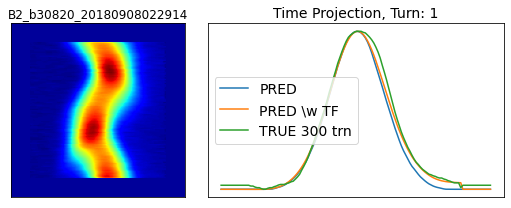

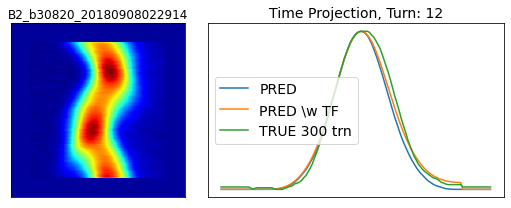

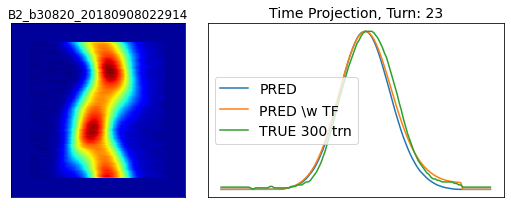

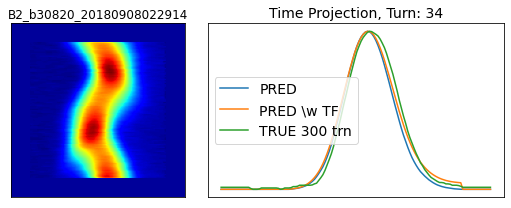

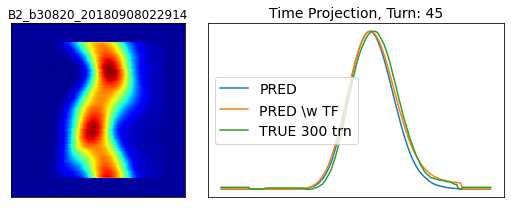

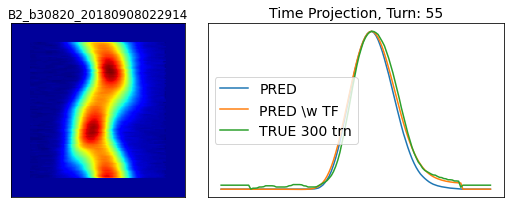

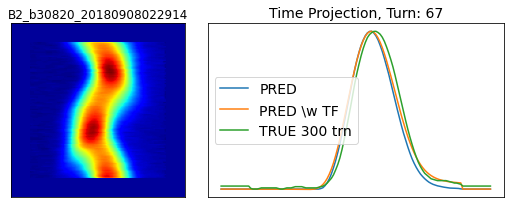

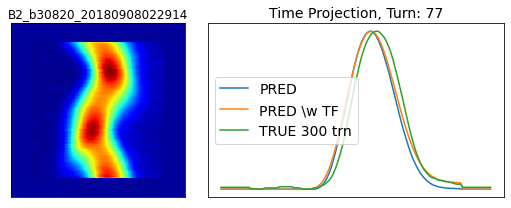

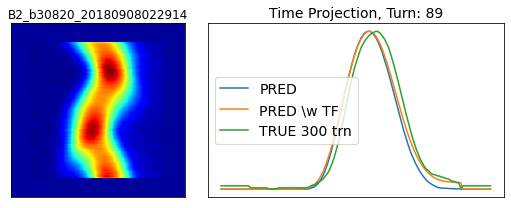

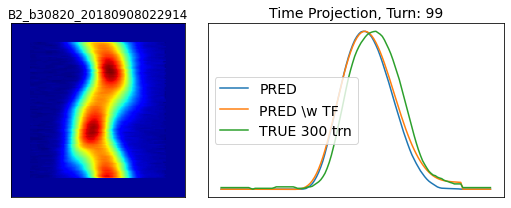

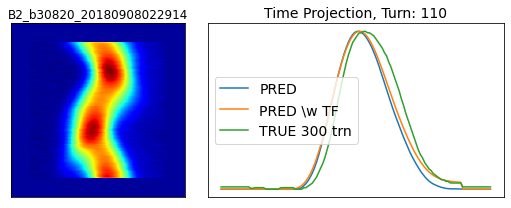

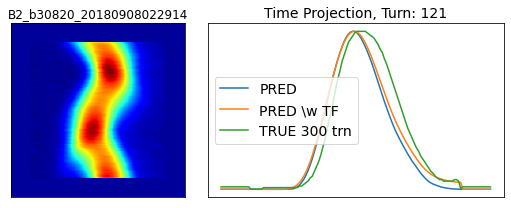

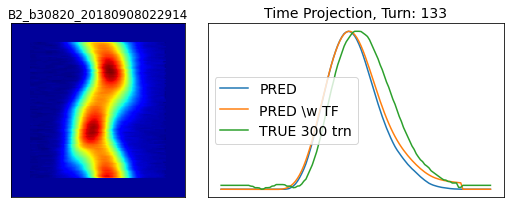

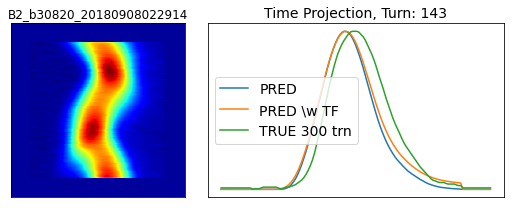

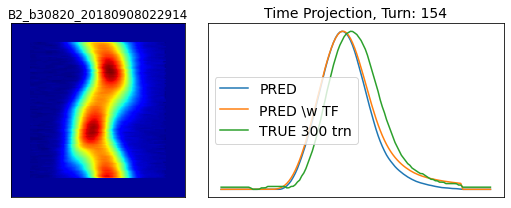

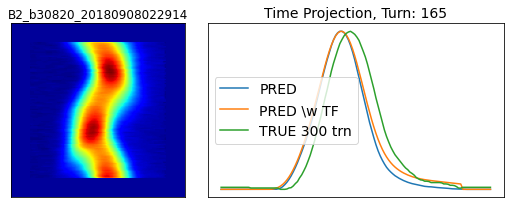

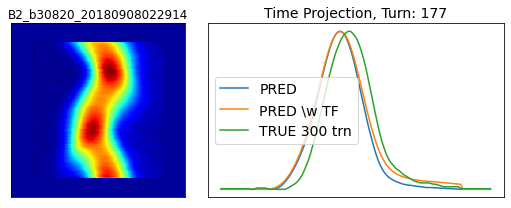

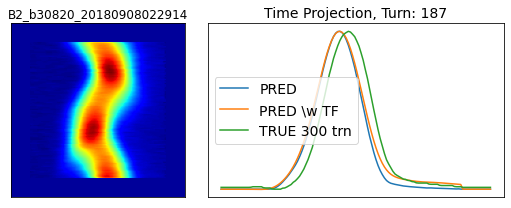

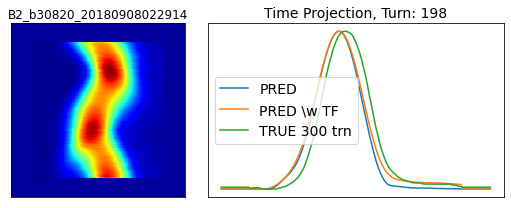

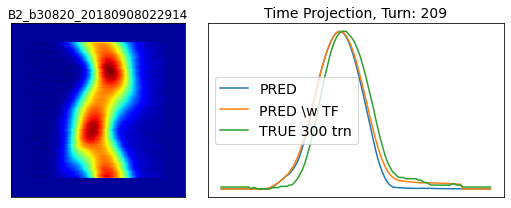

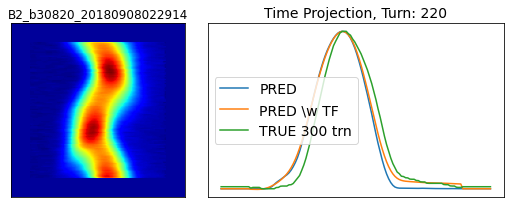

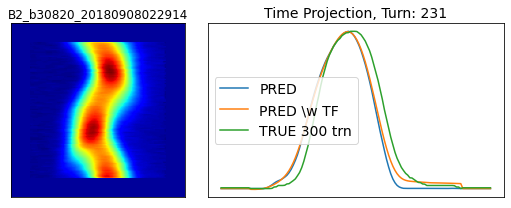

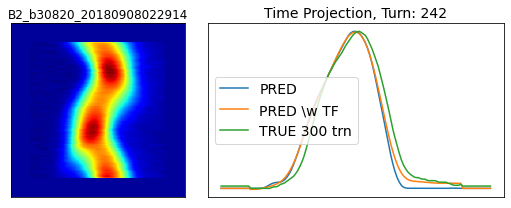

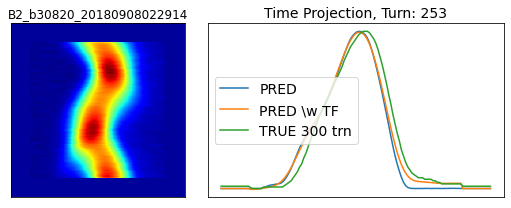

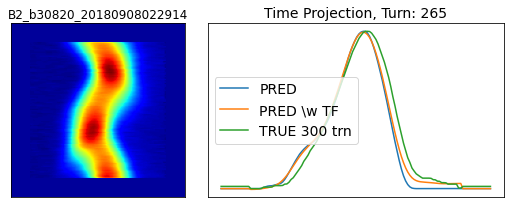

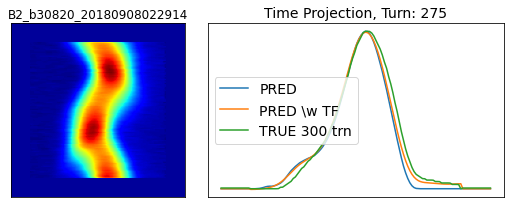

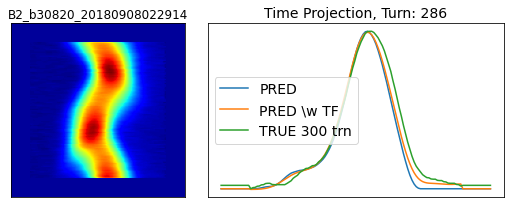

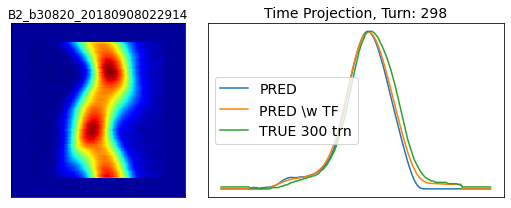

In [10]:
# Plot the predictions
out_dir = 'plots/real_data_correct_TF'
for norm_turn in norm_turns[:]:
    # expand turns to be equal to the number of test points
    turn_test = np.ones(len(wf_test), dtype=np.float32)*norm_turn
    # get the predictions
    # start_t = time.time()
    latent_pred, ps_pred = encDec.predictPS(wf_test, turn_test)
    # end_t = time.time()
    # print('Time taken:' , end_t - start_t)
    # Now I need to plot them
    # one directory per WF
    for i in np.arange(len(wf_test))[:1]:
        unnorm_turn = int(minmax_normalize_param(norm_turn, 0, 1, target_range=(1, 298)))
        # save in a figure the turn, latents, input image, output image
        os.makedirs(out_dir + f'/{wf_id[i]}', exist_ok=True)
        figname = out_dir+ f'/{wf_id[i]}/time_profile_{unnorm_turn:03d}.png'
        assess_model_real_data_no_table(wf_test[i], wf_id[i], bunch_profiles[i],
                        latent_pred[i], ps_pred[i], 
                        unnorm_turn, figname, savefig=False)

        # figname = out_dir+ f'/{wf_id[i]}/latents_time_projection_{unnorm_turn:03d}.png'
        # assess_model_real_data(wf_test[i], wf_id[i], bunch_profiles[i],
        #                 latent_pred[i], ps_pred[i], 
        #                 unnorm_turn, figname, savefig=True)



        

In [12]:
from utils import minMaxScaleIMG
from utils import loadTF, calc_bin_centers, bunchProfile_TFconvolve

time_scale = calc_bin_centers(0, 2.5e-9, 100)
tf_path = './tomo_data/transfer_functions/TF_B{}.h5'
freq_array, TF_array = loadTF(path=tf_path)


def reconstruct_wf(wf, wf_id, bunch_profile, ps_pred, turns, figname, savefig=False):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(9, 3))

    wf_s = minMaxScaleIMG(np.array(wf).reshape(128, 128).T)

    # axis = 0 : the turns (1 ps per turn)
    # axis = 1 : the vertical axis, the time bins
    # axis = 2 : the horizontal axis, the energy bins
    # axis = 3 : dummy axis, shape=1
    wf_pred = np.sum(ps_pred, axis=1)
    # print(wf_pred.shape)
    wf_pred = wf_pred.reshape((100, 128))
    _, wf_pred_tf = bunchProfile_TFconvolve((wf_pred.T)[14:-14], time_scale, freq_array, TF_array)
    wf_pred_tf = minMaxScaleIMG(wf_pred_tf)


    wf_pred = np.pad(wf_pred, ((14, 14), (0, 0)))
    wf_pred_tf = np.pad(wf_pred_tf.T, ((14, 14), (14, 14)))
    # print(wf_pred.shape)
    

    # # start with left plot, the original waterfall
    plt.sca(axes[0])
    plt.imshow(wf_s[14:-14, 14:-14], cmap='jet')
    plt.title(f'{wf_id.split("PROFILE_")[1]}', fontsize=12)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()

    # middle plot, the predicted waterfall, with TF
    plt.sca(axes[1])
    plt.imshow(wf_pred_tf[14:-14, 14:-14], cmap='jet')
    plt.title(f'Predicted \w TF', fontsize=12)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()

    # third plot, the difference waterfall, with TF
    plt.sca(axes[2])
    plt.imshow(np.abs(wf_s - wf_pred_tf)[14:-14, 14:-14], cmap='jet')
    plt.title(f'Diff', fontsize=12)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()


    plt.tight_layout()
    if savefig:
        plt.savefig(figname, dpi=100, bbox_inches='tight')
    else:
        plt.show()
    plt.close()


In [15]:

# normalize the turns
# select a number of turns (31)
selected_turns = np.linspace(1, 100, num=100, endpoint=True, dtype=np.float32)
# print(selected_turns)
norm_turns = minmax_normalize_param(selected_turns, np.min(selected_turns),
                                    np.max(selected_turns),
                                    target_range=(0, 1))

# Plot the predicted WF (extracted from the PS) next to the original WF
out_dir = 'plots/real_data_correct_TF/predicted_WFs/'
for i in np.arange(len(wf_test)):
    # Duplicate the wf_test multiple times
    input_wf = np.tile(wf_test[i], (len(norm_turns), 1, 1, 1))
    latent_pred, ps_pred = encDec.predictPS(input_wf, norm_turns)
    
    os.makedirs(out_dir + f'/{wf_id[i]}', exist_ok=True)
    figname = os.path.join(out_dir, f'{wf_id[i]}.png')
    reconstruct_wf(wf_test[i], wf_id[i], bunch_profiles[i], 
                   ps_pred, selected_turns, figname, savefig=True)
    # break


## Plot evolution of latent space params per bunch


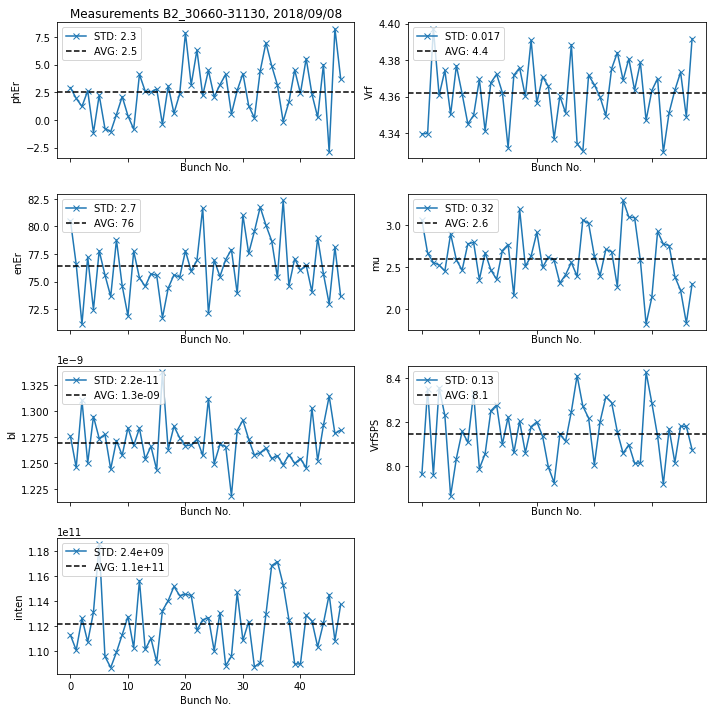

In [22]:
# Get latents for all input data
latent_pred = encDec.encode(wf_test, unnormalize=True)

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(10, 10), sharex=True)
axes = np.ravel(axes, order='F')
# bunch_ids = [name.split(''for name in wf_id]

for lat_id in range(latent_pred.shape[1]):
    y = latent_pred[:, lat_id]
    var_name = var_names[loss_weights[lat_id]]
    ax = axes[lat_id]
    plt.sca(ax)
    if lat_id == 0:
        plt.title('Measurements B2_30660-31130, 2018/09/08')
    plt.ylabel(var_name)
    mean = np.mean(y)
    std = np.std(y)
    plt.plot(y, marker='x', label=f'STD: {std:.2g}')
    plt.axhline(y=mean, label=f'AVG: {mean:.2g}', color='0', ls='--')
    plt.xlabel('Bunch No.')
    plt.legend(loc='upper left')
    # plt.xticks(np.arange(len(y)))
    plt.tight_layout()

fig.delaxes(axes[-1])

plt.savefig('plots/real_data_correct_TF/bunch-by-bunch-variation.png', dpi=300, bbox_inches='tight')
plt.show()
# plt.close()


## Compare real data to simulation data

In [ ]:
from utils import encoder_files_to_tensors, sample_files
# data_dir = './tomo_data/datasets_encoder_TF_16-12-22'
data_dir = './tomo_data/datasets_encoder_TF_03-03-23'

dataset_percent = 1
num_Turns_Case = 1
normalization = 'minmax'
img_normalize = 'off'
ps_normalize = 'off'

# real data: wf_test
real_x = wf_test
real_id = wf_id


In [ ]:
# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
assert os.path.exists(TRAINING_PATH)


# First the training data
file_names = sample_files(
    TRAINING_PATH, dataset_percent, keep_every=num_Turns_Case)
print(len(file_names))
start_t = time.time()
# read input, divide in features/ label, create tensors
sim_x, sim_y = encoder_files_to_tensors(file_names, normalization=normalization,
                                          img_normalize=img_normalize)
sim_x = np.array(sim_x).reshape(-1, 128, 128)
sim_y = np.array(sim_y)
total_time = time.time() - start_t
print(
    f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')


In [ ]:
# Now for every real_x, I need to find a sim_x that is as close as possible
# One metric to use is sum(diff(x1, x2))
min_diff_idx = [-1] * len(real_x)
min_diff_sum = [128 * 128] * len(real_x)

for i in range(len(real_x)):
    for j in range(len(sim_x)):
        diff_sum = np.sum(np.abs(real_x[i][14:-14,14:-14] - sim_x[j][14:-14,14:-14]))
        if diff_sum < min_diff_sum[i]:
            min_diff_sum[i] = diff_sum
            min_diff_idx[i] = j

In [ ]:
# Get the predictions for real and sim data
real_latents = encDec.encode(real_x, unnormalize=True).numpy()
sim_latents = sim_y[min_diff_idx]
sim_latents_unnorm = np.array(unnormalize_params(
        sim_latents[:, 0], sim_latents[:, 1], sim_latents[:, 2],
        sim_latents[:, 3], sim_latents[:, 4], sim_latents[:, 5],
        sim_latents[:, 6], normalization=normalization)).T

In [ ]:
nrows = 5
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(real_x)),
                          size=nrows, replace=False)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(10, 20), sharex=True)
# axes = np.ravel(axes)
# for i in range(len(axes)):
for i in range(len(sample)):
    ax = axes[i, 0]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(real_x[sample[i]], cmap='jet')
    ax.set_title(f'{real_id[sample[i]]}')
    plt.tight_layout()

    ax = axes[i, 1]
    plt.sca(ax)
    plt.tight_layout()

    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(sim_x[min_diff_idx[sample[i]]], cmap='jet')
    # title = ','.join([f'{y:.2f}' for y in sim_y[min_diff_idx[sample[i]]]])
    ax.set_title(f'Sim')

    ax = axes[i, 2]
    plt.sca(ax)
    plt.axis('off')

    rowLabels = [var_names[w] for w in loss_weights]
    # cellText = [[latent] for latent in latent_pred_unnorm]
    predicted = real_latents[sample[i]]
    simulated = sim_latents_unnorm[sample[i]]
    cellText = [[f'{predicted[i]:.3g}', f'{simulated[loss_weights[i]]:.3g}'] for i in range(len(predicted))]
    plt.table(cellText=cellText, rowLabels=rowLabels,
              colLabels=['Predicted', 'Simulation'], loc='center')
    plt.tight_layout()
